In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [70]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

In [71]:
df.head()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
0,682.814880,321.818176,543.817261,322.910706,50,50
1,683.180908,322.168823,543.886353,322.844757,50,50
2,683.322144,322.333282,544.013733,322.836456,50,50
3,682.994873,322.540405,543.606750,323.095856,50,50
4,682.957947,322.527924,543.460693,323.408539,50,50


In [72]:
df.describe()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,673.926233,334.146659,534.149458,336.672929,720.000000,395.000000
std,12.156191,7.833891,11.925018,8.590672,600.267499,309.092966
min,650.346069,321.818176,511.747284,322.836456,50.000000,50.000000
25%,661.587997,326.366951,522.449814,331.024651,50.000000,50.000000
50%,678.648041,335.026871,537.698273,336.569656,720.000000,395.000000
75%,685.226700,341.361580,544.994537,339.799240,1390.000000,740.000000
max,691.443359,348.099670,552.934753,356.132019,1390.000000,740.000000


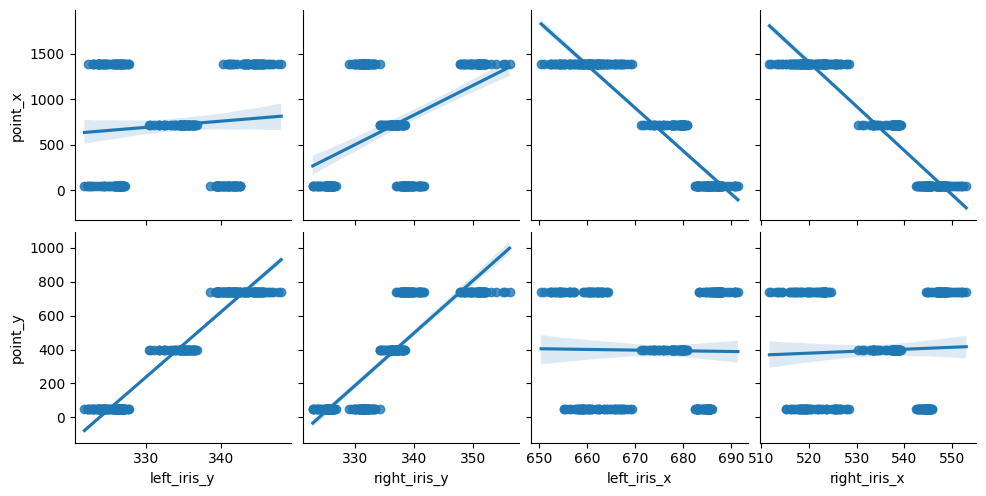

In [73]:
sns.pairplot(df, x_vars=['left_iris_y', 'right_iris_y', 'left_iris_x',
             'right_iris_x'], y_vars=['point_x', 'point_y'], kind='reg')
plt.show()

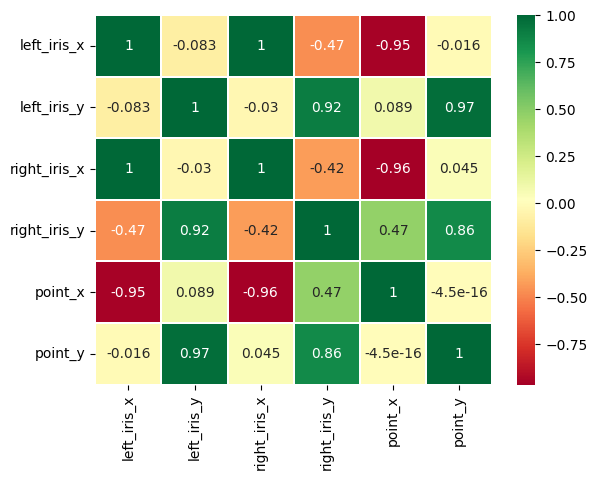

In [74]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

In [75]:
X_x = df[['left_iris_x', 'right_iris_x']]
y_x = df['point_x']

In [76]:
X.head()

,left_iris_y,right_iris_y
0,321.818176,322.910706
1,322.168823,322.844757
2,322.333282,322.836456
3,322.540405,323.095856
4,322.527924,323.408539


In [77]:
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=0.2)

In [78]:
model_x = linear_model.LinearRegression()
model_x.fit(X_train_x, y_train_x)
y_pred_x = model_x.predict(X_test_x)
r2_score(y_test_x, y_pred_x)

0.9322934453590273

In [79]:
y_pred_x

array([  62.17386954,   58.38269339, 1213.42902921,  176.95250819,
       -139.65993797,  203.24342851,  580.96348278,  173.47219457,
       1531.30716824, 1612.4892875 , 1346.87784346,  236.14648638,
       1578.51357091, 1158.72138656, 1478.20471581, 1566.99098911,
         53.43943265, 1218.03269426,  785.0598072 , 1466.3128383 ,
       1296.92787024, 1426.39292065,   39.66996786, 1386.73649463,
       1525.47873625, 1161.83034759,   41.23623869,  963.1951809 ,
         35.30870623, 1355.56087942, 1250.3665102 ,  569.21290931,
          1.92328614, 1551.58904179,   -9.22895887, 1279.26400499,
       1438.91264553,  -26.88994351,  539.20544148,  755.56867042,
        186.36858706,  809.03813154,  583.05781746,  131.14414942,
       -142.06685195, 1709.50252689, 1304.03769372,  732.81060628,
       1223.91564379,  574.57947836,  537.2838118 ,  591.04704402,
       1680.50270766, 1484.63682541, 1232.93975885,  554.75024337,
        213.99928836,  228.1638167 ,  292.76217934, 1788.14778

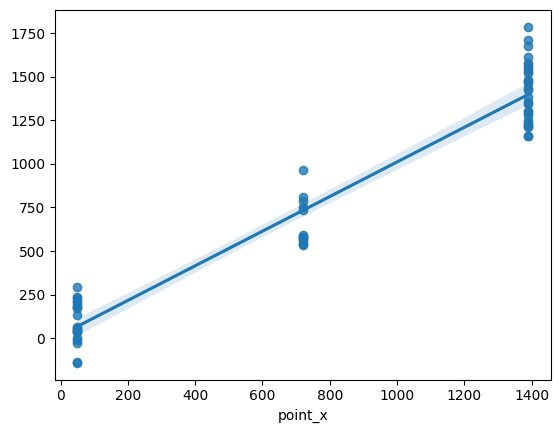

In [80]:
sns.regplot(x=y_test_x, y=y_pred_x)
plt.show()

In [81]:
X_y = df[['left_iris_y', 'right_iris_y']]
y_y = df['point_y']

In [82]:
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X_y, y_y, test_size=0.2)

In [83]:
model = linear_model.LinearRegression()
model.fit(X_train_y, y_train_y)
y_pred_y = model.predict(X_test_y)
r2_score(y_test_y, y_pred_y)

0.9373308423902496

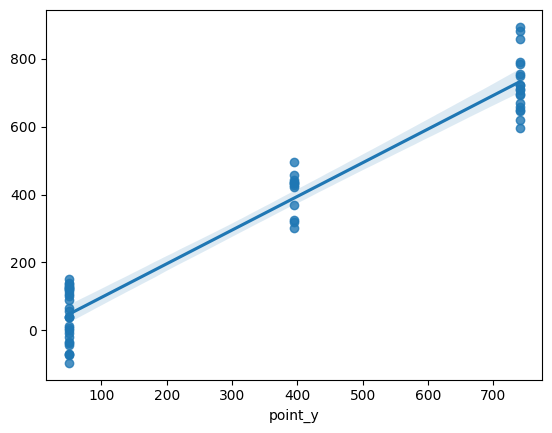

In [84]:
sns.regplot(x=y_test_y, y=y_pred_y)
plt.show()

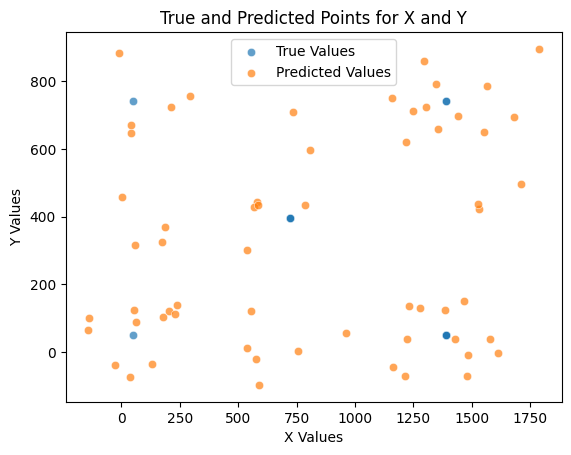

In [89]:
data = {'True X': y_test_x, 'Predicted X': y_pred_x,
        'True Y': y_test_y, 'Predicted Y': y_pred_y}

sns.scatterplot(x='True X', y='True Y', data=data,
                label='True Values', alpha=0.7)
sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                label='Predicted Values', alpha=0.7)

plt.title('True and Predicted Points for X and Y')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.legend()

plt.show()